#   <center>Сверточная нейронная сеть</center>

### Импортируем библиотеки

Для создания нейросети будем использовать фреймворк *Keras*

<span style="color:red"> **Внимание:** в данной работе использовалась версия *tensorflow==2.0*, поскольку возникли проблемы с *BatchNormalization* в новой версии. </span>

In [1]:
import cv2
import numpy as np
import matplotlib
import os
from matplotlib import pyplot as plt

import tensorflow as tf
from keras.models import Model
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Dropout, merge
from keras.layers.normalization import BatchNormalization


from jupyterthemes import jtplot

matplotlib.rcParams['figure.figsize'] = (8,8)
jtplot.style('onedork')

Using TensorFlow backend.


### Вспомогательные функции

Размер *numpy* массива для данных расчитывается здесь.

In [2]:
def get_size(path, classes):
    size = 0
    for cl in classes:
        size += len(next(os.walk(path + cl))[2])
    ans = [size]
    one_path = path + classes[0] + '/' + next(os.walk(path + classes[0]))[2][0]
    one_im = cv2.imread(one_path)
    ans.extend(list(one_im.shape))
    return tuple(ans)

Функция импортирует изображения из папки в датасет.

In [3]:
def img_data_reader(path, classes):
    if path[-1] != '/':
        path += '/'
    size = get_size(path, classes)
    X_cols = np.zeros(size).astype(np.uint8)
    Y_cols = np.zeros((size[0], len(classes))).astype(np.uint8)
    last_bound = 0
    for i in range(len(classes)):
        images = next(os.walk(path + classes[i]))[2]
        for j in range(len(images)):
            X_cols[last_bound + j] = cv2.imread(path + classes[i] + '/' + images[j])
            Y_cols[last_bound + j][i] = 1
        last_bound += len(images)
    return X_cols, Y_cols

Функция для случайного разбиения датасета на тренировочный и валидационный.

In [4]:
def split_train_test(data, test_ratio, state = 7):    
    shuffled_indices = np.random.RandomState(seed=state).permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return train_indices, test_indices 

### Извлекаем данные

Для тренировки в первом случае будем использовать эмоджи, сделанные Максимом и Линой, а для тестирования, эмоджи, нарисованные Ромой.

In [5]:
classes = ['good', 'bad', 'ugly']
path_to_max = "data/max"
path_to_lina = "data/lina"
path_to_roma = "data/roma"

Извлекаем данные из директорий с нарезанными изображениями. Изображения разных классов в них разбиты по папкам, название которых совпадает с названием классов. Вместе с данными формируем наборы меток в бинарном виде.

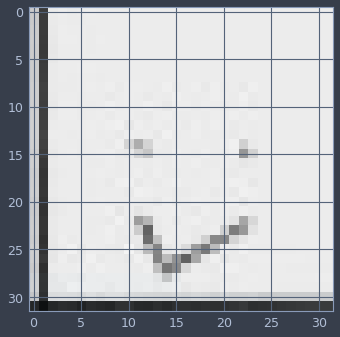

In [6]:
X_max, Y_max = img_data_reader(path_to_max, classes)
plt.imshow(X_max[9])

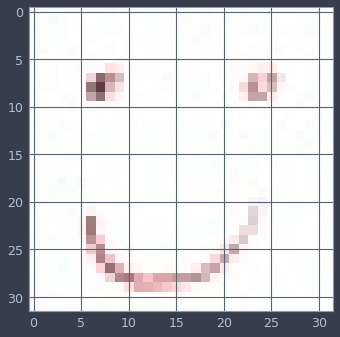

In [7]:
X_lina, Y_lina = img_data_reader(path_to_lina, classes)
plt.imshow(X_lina[100])

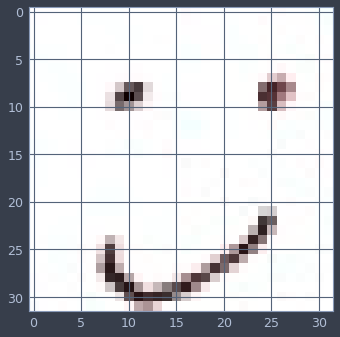

In [8]:
X_roma, Y_roma = img_data_reader(path_to_roma, classes)
plt.imshow(X_roma[1])

И объединим два датасета участников в один общий тренировочный набор. Третий датасет - тестовый.

In [9]:
X_train_1 =  np.concatenate([X_max, X_lina])
Y_train_1 =  np.concatenate([Y_max, Y_lina])
X_test_1 = X_roma
Y_test_1 = Y_roma
print("Количество изображений для обучения нейросети:", X_train_1.shape[0])
print("Количество изображений для тренировки нейросети:", X_test_1.shape[0])

Количество изображений для обучения нейросети: 639
Количество изображений для тренировки нейросети: 324


Для второго тренировочного набора возьмем 80% изображений всех участников команды.

In [10]:
X_full =  np.concatenate([X_max, X_lina, X_roma])
Y_full =  np.concatenate([Y_max, Y_lina, Y_roma])

train_i, test_i = split_train_test(X_full, 0.2)

X_train_2 = X_full[train_i]
Y_train_2 = Y_full[train_i]
X_test_2 = X_full[test_i]
Y_test_2 = Y_full[test_i]

### Нормализация данных

Для корректной работы алгоритма следует нормализовать данные. Оптимальнам выбором здесь является **min-max** нормализация, поскольку она сохранит все закономерности в данных: 

$$\overline{X} = \displaystyle\frac{X - \min{X}}{\max{X} - \min{X}}$$

В данном случае мы можем просто поделить на 255 в силу свойств числового представления изображения.

In [11]:
X_train_1 = X_train_1.astype(np.float32)
X_train_1 /= 255.0
X_test_1 = X_test_1.astype(np.float32)
X_test_1 /= 255.0

In [12]:
X_train_2 = X_train_2.astype(np.float32)
X_train_2 /= 255.0
X_test_2 = X_test_2.astype(np.float32)
X_test_2 /= 255.0

### Проектирование сети

Опишем гиперпараметры нейронной сети, которые будем менять для достижения лучшего результата.

In [13]:
b_size = 32 # batch size
epochs = 30 # num of full set itterations
k_size = 3  # kernel size 3x3
p_size = 2 # subdisc size 2x2
depth_1 = 8 # num of features we find in first conv
depth_2 = 16 # num of features we find in second conv
depth_3 = 24 # num of features we find in third conv
drop_p = 0.2
h_size = 128

Первый слой сети - входное изображение в *Keras* декларируется с помощью класса **Input**.

In [14]:
inpt = Input(shape = X_train_1.shape[1:])

Для ускорения и улучшения качества сходимости следует использовать начальную инициализацию слоев. Рекомендуется выбирать функцию инициализации *Ге* для слоев с функцией активации **ReLU** и функцию активации *Хавьера* для слоев с функцией **softmax**.

Поскольку мы имеем всего 3 различных класса и примитивные изображения, для получения достойного результата нам должно хватить 3 **сверточных** слоев. 

После первого и второго слоя поставим **субдискредитирующие** слои, чтобы нейросеть сосредотачивалась на наиболее ярко выраженных признаках в изображениях.

Чтобы меньше зависить от того, какое значение полных проходов по датасету выбрать и не переобучиться, воспользуемся техникой **батч-нормализации** после каждого нейронного слоя, поскольку она выполняет две полезные функции:
    - ускоряет процесс обучения
    - регуляризирует параметры

In [15]:
conv_1 = Conv2D(depth_1, kernel_size=k_size, activation="relu", \
                kernel_initializer="he_uniform")(inpt)
conv_1 = BatchNormalization(axis=1)(conv_1)

pool_1 = MaxPooling2D(pool_size=(p_size, p_size))(conv_1)

conv_2 = Conv2D(depth_2, kernel_size=k_size, activation="relu", \
                kernel_initializer="he_uniform")(pool_1)
conv_2 = BatchNormalization(axis=1)(conv_2)

pool_2 = MaxPooling2D(pool_size=(p_size, p_size))(conv_2)

conv_3 = Conv2D(depth_3, kernel_size=k_size, activation="relu", \
                kernel_initializer="he_uniform")(pool_2)
conv_3 = BatchNormalization(axis=1)(conv_3)


flat = Flatten()(conv_2) # makes 1D

После сверточных слоев добавим 2 слоя **перцептрона**, регулязацию которых выполним при помощи техники **dropout**. Функцию активации первого слоя будем использовать наиболее популярную - **ReLU**, а для второго слоя воспользуемся непрерывной функцией - **softmax**, результаты который можно интерпретировать как вероятности определения объекта к классу.

In [16]:
drop_1 = Dropout(drop_p)(flat)
hid_1 = Dense(h_size, kernel_initializer="he_uniform", activation='relu')(drop_1)
hid_1 = BatchNormalization(axis=1)(hid_1)
 

drop_2 = Dropout(drop_p)(hid_1)
outpt = Dense(len(classes), kernel_initializer="glorot_uniform", activation='softmax')(drop_2)

Для работы с сетью в *Keras* есть класс **Model**.

In [17]:
network = Model(input=inpt, output=outpt)

/home/max/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  """Entry point for launching an IPython kernel.


Скомпилируем модель, используя в качестве *loss-function* предназначенную для задач классификации *категориальную кроссэнтропию*, а для метода градиентного спуска *оптимизацию Адама*. 

В качестве метрики мы выбрали $Accuracy = \displaystyle\frac{TP + TN}{M}$, где  $M$ - размер данных, поскольку в нашей задаче примерно равное количество объектов каждого из классов.

In [18]:
network.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Сохраним скомпилированную модель, чтобы обучить ее несколько раз на разных данных.

In [19]:
network.save("networks/clear.h5")

### Тренировка сети

#### Первый набор

Обучение модели.

In [20]:
hist = network.fit(X_train_1, Y_train_1, batch_size = b_size, epochs=epochs, \
                   validation_data=(X_test_1, Y_test_1))

Train on 639 samples, validate on 324 samples
Epoch 1/30
639/639 [==============================] - 6s 10ms/step - loss: 1.1905 - accuracy: 0.4789 - val_loss: 1.0197 - val_accuracy: 0.5278
Epoch 2/30
639/639 [==============================] - 3s 5ms/step - loss: 0.4413 - accuracy: 0.8451 - val_loss: 1.6577 - val_accuracy: 0.5185
Epoch 3/30
639/639 [==============================] - 4s 7ms/step - loss: 0.1885 - accuracy: 0.9390 - val_loss: 1.5117 - val_accuracy: 0.4722
Epoch 4/30
639/639 [==============================] - 4s 6ms/step - loss: 0.1444 - accuracy: 0.9468 - val_loss: 2.0924 - val_accuracy: 0.3333
Epoch 5/30
639/639 [==============================] - 5s 9ms/step - loss: 0.1078 - accuracy: 0.9656 - val_loss: 0.9308 - val_accuracy: 0.4969
Epoch 6/30
639/639 [==============================] - 4s 7ms/step - loss: 0.0674 - accuracy: 0.9797 - val_loss: 1.3146 - val_accuracy: 0.3858
Epoch 7/30
639/639 [==============================] - 3s 4ms/step - loss: 0.0473 - accuracy: 0.9859 -

Графическая иллюстрация процесса обучения.

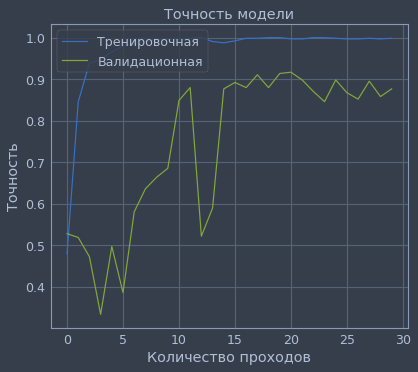

In [21]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Точность модели')
plt.ylabel('Точность')
plt.xlabel('Количество проходов')
plt.legend(['Тренировочная', 'Валидационная'], loc='upper left')
plt.show()

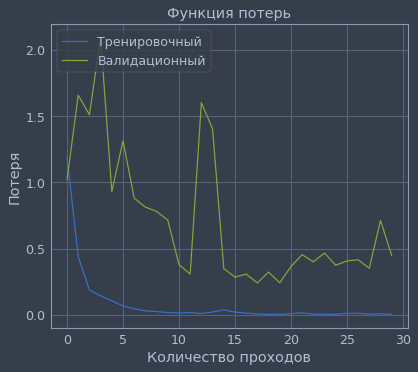

In [22]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Функция потерь')
plt.ylabel('Потеря')
plt.xlabel('Количество проходов')
plt.legend(['Тренировочный', 'Валидационный'], loc='upper left')
plt.show()

Показатели качества модели на тестовых данных.

In [23]:
print('Тестирование:')
scores = network.evaluate(X_test_1, Y_test_1, verbose = 2)
print("%s: %.3f" % (network.metrics_names[0], scores[0])) # loss (потери)
print("%s: %.2f%%" % (network.metrics_names[1], scores[1]*100)) # acc (точность)

Тестирование:
loss: 0.450
accuracy: 87.65%


Сохранение результата

In [24]:
filename = "networks/conv_network1.h5"
network.save(filename)


##### Первая сверточная нейронная сеть готова!

#### Второй набор

Загрузим чистую модель.

In [25]:
network = load_model("networks/clear.h5")

Обучение модели

In [26]:
hist = network.fit(X_train_2, Y_train_2, batch_size = b_size, epochs=epochs, \
                   validation_data=(X_test_2, Y_test_2))

Train on 771 samples, validate on 192 samples
Epoch 1/30
771/771 [==============================] - 10s 13ms/step - loss: 1.1263 - accuracy: 0.5175 - val_loss: 1.2360 - val_accuracy: 0.4323
Epoch 2/30
771/771 [==============================] - 4s 5ms/step - loss: 0.4353 - accuracy: 0.8353 - val_loss: 0.8920 - val_accuracy: 0.6094
Epoch 3/30
771/771 [==============================] - 3s 4ms/step - loss: 0.2432 - accuracy: 0.9170 - val_loss: 0.7127 - val_accuracy: 0.6823
Epoch 4/30
771/771 [==============================] - 3s 4ms/step - loss: 0.1541 - accuracy: 0.9533 - val_loss: 0.8112 - val_accuracy: 0.5990
Epoch 5/30
771/771 [==============================] - 3s 4ms/step - loss: 0.0962 - accuracy: 0.9767 - val_loss: 1.7587 - val_accuracy: 0.4271
Epoch 6/30
771/771 [==============================] - 3s 4ms/step - loss: 0.1513 - accuracy: 0.9507 - val_loss: 0.7404 - val_accuracy: 0.6302
Epoch 7/30
771/771 [==============================] - 3s 4ms/step - loss: 0.0862 - accuracy: 0.9792 

Графическая иллюстрация процесса обучения.

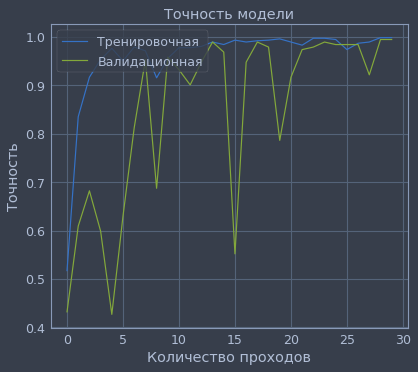

In [27]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Точность модели')
plt.ylabel('Точность')
plt.xlabel('Количество проходов')
plt.legend(['Тренировочная', 'Валидационная'], loc='upper left')
plt.show()

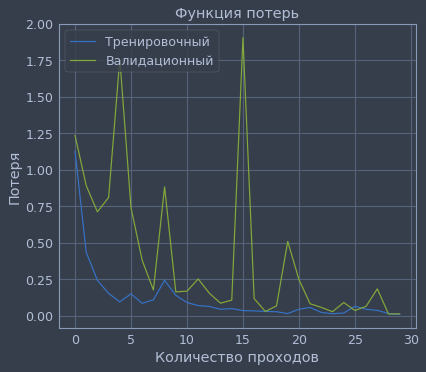

In [28]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Функция потерь')
plt.ylabel('Потеря')
plt.xlabel('Количество проходов')
plt.legend(['Тренировочный', 'Валидационный'], loc='upper left')
plt.show()

Показатели качества модели на тестовых данных.

In [29]:
print('Тестирование:')
scores = network.evaluate(X_test_2, Y_test_2, verbose = 2)
print("%s: %.3f" % (network.metrics_names[0], scores[0])) # loss (потери)
print("%s: %.2f%%" % (network.metrics_names[1], scores[1]*100)) # acc (точность)

Тестирование:
loss: 0.014
accuracy: 99.48%


Сохранение результата

In [30]:
filename = "networks/conv_network2.h5"
network.save(filename)

##### Вторая сверточная нейронная сеть готова!

### Итог

Мы спроектировали сверточную нейросеть с помощью фреймворка *Keras* и обучили ее на 2 наборах данных. Как и ожидалось, результат при тренировке на 80% и тестирования на 20% от общего набора превзошел результат тренировки на данных от 2 участниках и тестирования на данных от третьего, поскольку в первом случае модель имела больше данных для обучения и этот набор был более варьиативен, так как имел образцы изображений каждого из участников. Однако второй случай отражает более реальные возможности нашей модели классифицировать эмоджи от пользователей. 

Для более высоких показателей качества, необходим гораздо больший объем данных для обучения, но даже сейчас модель хорошо зарекомндовала себя, поскольку показала высокий результат при классифкации. Но не стоит забывать, что мы использовали сравнительно чистые данные и задача, которую мы ставили перед нашей сетью была примитиной.

In [2]:
%%bash 
rm networks/clear.h5